# Sparse Subspace Clustering for User Identification
  
Standard recommendation methods rely on the assumption that each account is used by a single user. In reality though, multiple users may be sharing one account. In these cases, recommendations may lean toward more dominant users, or generalize to the combined weak preferences of multiple users. In addition, with shared accounts, services may be losing potential revenue. To solve these issues, the best way is to distinguish the users sharing the account. This is known to be a chicken and egg problem, because if we know the number of users sharing the account beforehand, it is relatively easy to allocate users to the items of their preferences, and if we know the pairings of users and items beforehand, it is trivial to discover the number of users using the account. Since this problem setting is analogous to the subspace clustering setting, where the objective is to find the number of subspaces, and the data points belonging to each subspace, we apply subspace clustering to this problem. Thus, in this project the objective is to apply subspace clustering to an account x item matrix, to distinguish the accounts which are shared by multiple users. Specifically, we apply Sparse Subspace Clustering to the MovieLens dataset, with major focus on discovering the pairings of users and movies in the multiple user setting. We show results of this experiment and give directions we could take for further research.

Related Work:    
This project is based off of the paper "Guess Who Rated This Movie:Identifying Users Through Subspace Clustering" by Zhang et al. [1], which attempted to apply Generalized Principal Component Analysis (GPCA), which is a subspace clustering method. Unfortunately, they were not able to produce good results with GPCA due to the presence of noise in the data. Meanwhile, Sparse Subspace Clustering (SSC) [4] is currently the state-of-art in subspace clustering. Therefore, here the objective is to apply SSC to a similar setting and see how SSC acts.


## Contents
1. Preprocessing of MovieLens (small) data
2. Obtain Movie Representations with Matrix Factorization
3. Create Artificial Two-User Accounts
4. Apply K-Means, Spectral Clustering, and Sparse Subspace Clustering to each account
5. Evaluation
6. Future Directions

## 1. Preprocessing of MovieLens (small) data

MovieLens dataset taken from https://grouplens.org/datasets/movielens/  will be used.  
(Out of the different MovieLens datasets, the small MovieLens dataset will be used for simplicity.)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from helper import create_new_userid, create_new_movieid

In [2]:
df = pd.read_csv('movielens/ratings.csv')

In [3]:
print('Number of unique users: {}'.format(len(np.unique(df.userId))))
print('Number of unique movies: {}'.format(len(np.unique(df.movieId))))
print('Types of ratings: {}'.format(np.unique(df.rating)))

Number of unique users: 610
Number of unique movies: 9724
Types of ratings: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


Statistics of MovieLens Data

In [4]:
df.groupby('userId').count().describe()

,movieId,rating,timestamp
count,610.000000,610.000000,610.000000
mean,165.304918,165.304918,165.304918
std,269.480584,269.480584,269.480584
min,20.000000,20.000000,20.000000
25%,35.000000,35.000000,35.000000
50%,70.500000,70.500000,70.500000
75%,168.000000,168.000000,168.000000
max,2698.000000,2698.000000,2698.000000


Balancing the number of movies watched by each user to order of 100s, and removing movies that were viewed only once

In [5]:
# Remove users that rated less than 100 movies, and more than 999 movies
df = df.groupby('userId').filter(lambda userId: len(userId) >= 100)
df = df.groupby('userId').filter(lambda userId: len(userId) < 1000)

# Remove movies that only appear once
df = df.groupby('movieId').filter(lambda movieId: len(movieId) > 1) 

In [6]:
print('Number of unique users: {}'.format(len(np.unique(df.userId))))
print('Number of unique movies: {}'.format(len(np.unique(df.movieId))))
print('Types of ratings: {}'.format(np.unique(df.rating)))

Number of unique users: 236
Number of unique movies: 4860
Types of ratings: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


Create new_userId and new_movieId so that they all start from 0 and increase by 1's  
(Easier to align with matrices/arrays later)

In [7]:
# Create new_userId
df['new_userId'] = create_new_userid(df)

# Create new_movieId
df['new_movieId'] = create_new_movieid(df)

In [8]:
df = df.sort_values(['new_userId', 'new_movieId'])

## 2. Obtain Movie Representations with Matrix Factorization

In [9]:
from MF import ML_MatrixFactorization

Uses Matrix Factorization with bias and regularization terms for both users and items.  
Updates are done with alternating least squares.

In [12]:
model = ML_MatrixFactorization(k = 10, lmd_u = 10, lmd_v = 10)
model.fit(df, epochs=30)

HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

Epoch 0
Objective Value: 1233933.1969017838
Epoch 1
Objective Value: 252143.09182546264
Epoch 2
Objective Value: 56353.62539505561
Epoch 3
Objective Value: 14827.857888174283
Epoch 4
Objective Value: 4763.679462428649
Epoch 5
Objective Value: 1849.6203660057545
Epoch 6
Objective Value: 852.6197346201792
Epoch 7
Objective Value: 467.6063587230657
Epoch 8
Objective Value: 294.64121645440656
Epoch 9
Objective Value: 213.6006942078346
Epoch 10
Objective Value: 167.46728091377125
Epoch 11
Objective Value: 141.5692684837187
Epoch 12
Objective Value: 125.33747255527526
Epoch 13
Objective Value: 113.39576166813885
Epoch 14
Objective Value: 104.90378701628588
Epoch 15
Objective Value: 97.71922939843022
Epoch 16
Objective Value: 91.54414231354956
Epoch 17
Objective Value: 86.25272077493942
Epoch 18
Objective Value: 81.80637002493084
Epoch 19
Objective Value: 77.91245598587824
Epoch 20
Objective Value: 75.06908944029747
Epoch 21
Objective Value: 72.67320866520555
Epoch 22
Objective Value: 70.6693

In [15]:
# Save u and v matrices
# np.save('outputs/MF_u_final.npy', model.u)
# np.save('outputs/MF_v_final.npy', model.v)

In [10]:
# Load u and v matrices
u = np.load('outputs/MF_u_final.npy')
v = np.load('outputs/MF_v_final.npy')

In [11]:
# Standardize v per row (Mostly because Kmeans doesn't work without this)
v = (v - np.repeat(np.mean(v, axis=1), v.shape[1]).reshape(v.shape))/np.repeat(np.std(v, axis=1), v.shape[1]).reshape(v.shape)

## 3. Create Artificial Two-User Accounts

In [12]:
from helper import output_paired_users, output_corresponding_movies

In [12]:
# Make pairs of users randomly
user_pairs_arr = output_paired_users(df)

# Get corresponding movies of paired users
account_movies_arr = output_corresponding_movies(df, user_pairs_arr)

In [13]:
# Save user_pairs_arr and account_movies_arr
# np.save('outputs/user_pairs_arr_final.npy', user_pairs_arr)
# np.save('outputs/account_movies_arr_final.npy', account_movies_arr)

In [2]:
# Load saved u and v matrices
user_pairs_arr = np.load('outputs/user_pairs_arr_final.npy', allow_pickle=True)
account_movies_arr = np.load('outputs/account_movies_arr_final.npy', allow_pickle=True)

## 4. Apply K-Means, Spectral Clustering, and Sparse Subspace Clustering to each account

Here, the assumption is that if we cluster the movie representations appended with the rating of users per account, we will be able to distinguish the users in that account.

In [14]:
from cluster import cluster_labels_with_acc

### (i) Kmeans

In [31]:
kmeans_acc_list, kmeans_pred_list = cluster_labels_with_acc(v, df, user_pairs_arr, account_movies_arr, 2, 'kmeans')

HBox(children=(IntProgress(value=0, max=118), HTML(value='')))

In [32]:
#np.save('outputs/kmeans_acc_final.npy', np.array(kmeans_acc_list))
#np.save('outputs/kmeans_pred_final.npy', np.array(kmeans_pred_list))

In [3]:
kmeans_acc_list = np.load('outputs/kmeans_acc_final.npy', allow_pickle=True)
kmeans_pred_list = np.load('outputs/kmeans_pred_final.npy', allow_pickle=True)

### (ii) Spectral Clustering

In [35]:
spectral_acc_list, spectral_pred_list = cluster_labels_with_acc(v, df, user_pairs_arr, 
                                                                account_movies_arr, 2, 'spectral')

HBox(children=(IntProgress(value=0, max=118), HTML(value='')))

In [36]:
#np.save('outputs/spectral_acc_final.npy', np.array(spectral_acc_list))
#np.save('outputs/spectral_pred_final.npy', np.array(spectral_pred_list))

In [4]:
spectral_acc_list = np.load('outputs/spectral_acc_final.npy', allow_pickle=True)
spectral_pred_list = np.load('outputs/spectral_pred_final.npy', allow_pickle=True)

### (iii) Sparse Subspace Clustering

In [1]:
ssc_acc_list, ssc_pred_list = cluster_labels_with_acc(v, df, user_pairs_arr, 
                                                                 account_movies_arr, 2, 'ssc')

In [41]:
#np.save('outputs/ssc_acc_final.npy', np.array(ssc_acc_list))
#np.save('outputs/ssc_pred_final.npy', np.array(ssc_pred_list))

In [5]:
ssc_acc_list = np.load('outputs/ssc_acc_final.npy', allow_pickle=True)
ssc_pred_list = np.load('outputs/ssc_pred_final.npy', allow_pickle=True)

## 5. Evaluation

### Similarity  
(How true labels and clusters match)

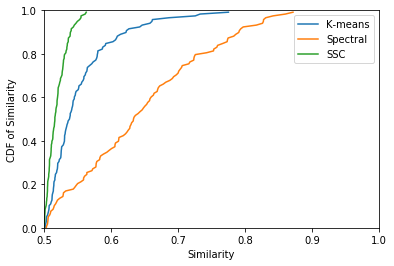

In [8]:
x1 = np.sort(kmeans_acc_list)
x2 = np.sort(spectral_acc_list)
x3 = np.sort(ssc_acc_list)
y = np.arange(len(x1))/float(len(x1))
labels = ['K-means', 'Spectral', 'SSC']
plt.plot(x1, y)
plt.plot(x2, y)
plt.plot(x3, y)
plt.xlim(0.5,1)
plt.ylim(0, 1)
plt.legend(labels)
plt.xlabel('Similarity')
plt.ylabel('CDF of Similarity')
#plt.savefig('outputs/similarities_k10_lmd_10_final.png')
plt.show()

Regarding similarity, SSC performed the worst. But Spectral Clustering clusters movie rated by each account mostly into one user. On the other hand, K-means and Spectral are making more balanced clusters, although in some cases K-means clusters movies rated by an account to a single user as well.

### Genre distribution in clusters

In [6]:
from helper import collect_movies_in_clusters, get_genres, calculate_cluster_ratio_difference
from collections import Counter
from matplotlib.ticker import PercentFormatter

In [7]:
# Collect predicted movie clusters of first multiple user account
kmeans_0, kmeans_1 = collect_movies_in_clusters(account_movies_arr[0], kmeans_pred_list[0])
spectral_0, spectral_1 = collect_movies_in_clusters(account_movies_arr[0], spectral_pred_list[0])
ssc_0, ssc_1 = collect_movies_in_clusters(account_movies_arr[0], ssc_pred_list[0])

In [8]:
# Get all genre's corresponding to movie_id's in a list
kmeans_0_genres = get_genres(kmeans_0)
kmeans_1_genres = get_genres(kmeans_1)
spectral_0_genres = get_genres(spectral_0)
spectral_1_genres = get_genres(spectral_1)
ssc_0_genres = get_genres(ssc_0)
ssc_1_genres = get_genres(ssc_1)

In [9]:
# Get number of times each genre appeared in each cluster
kmeans_0_keys = list(Counter(kmeans_0_genres).keys())
kmeans_0_values = list(Counter(kmeans_0_genres).values())
kmeans_1_keys = list(Counter(kmeans_1_genres).keys())
kmeans_1_values = list(Counter(kmeans_1_genres).values())

spectral_0_keys = list(Counter(spectral_0_genres).keys())
spectral_0_values = list(Counter(spectral_0_genres).values())
spectral_1_keys = list(Counter(spectral_1_genres).keys())
spectral_1_values = list(Counter(spectral_1_genres).values())

ssc_0_keys = list(Counter(ssc_0_genres).keys())
ssc_0_values = list(Counter(ssc_0_genres).values())
ssc_1_keys = list(Counter(ssc_1_genres).keys())
ssc_1_values = list(Counter(ssc_1_genres).values())

#### Kmeans cluster 0 and 1

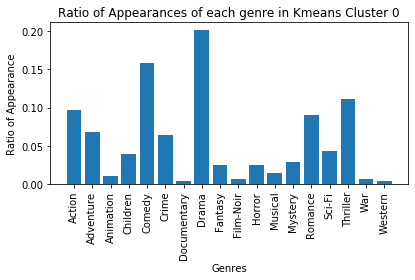

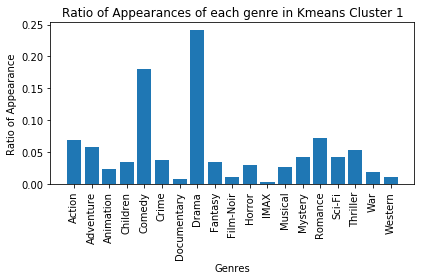

In [43]:
plt.bar(sorted(kmeans_0_keys), [x/np.sum(kmeans_0_values) for _,x in sorted(zip(kmeans_0_keys,kmeans_0_values))], align='center')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Ratio of Appearance')
plt.title('Ratio of Appearances of each genre in Kmeans Cluster 0')
plt.tight_layout()
#plt.savefig('outputs/kmeans_0_genres_final.png')
plt.show()

plt.bar(sorted(kmeans_1_keys), [x/np.sum(kmeans_1_values) for _,x in sorted(zip(kmeans_1_keys,kmeans_1_values))], align='center')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Ratio of Appearance')
plt.title('Ratio of Appearances of each genre in Kmeans Cluster 1')
plt.tight_layout()
#plt.savefig('outputs/kmeans_1_genres_final.png')
plt.show()

#### Spectral Clustering cluster 0 and 1

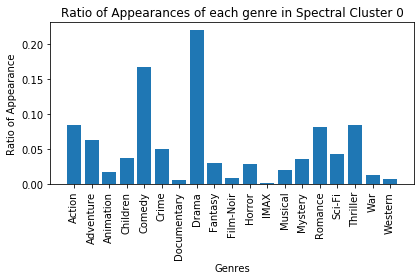

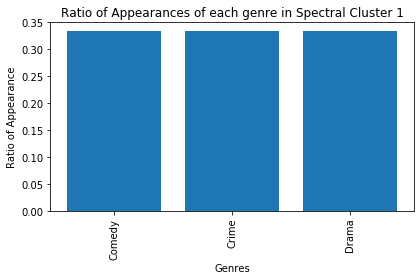

In [45]:
plt.bar(sorted(spectral_0_keys), [x/np.sum(spectral_0_values) for _,x in sorted(zip(spectral_0_keys,spectral_0_values))], align='center')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Ratio of Appearance')
plt.title('Ratio of Appearances of each genre in Spectral Cluster 0')
plt.tight_layout()
#plt.savefig('outputs/spectral_0_genres_final.png')
plt.show()

plt.bar(sorted(spectral_1_keys), [x/np.sum(spectral_1_values) for _,x in sorted(zip(spectral_1_keys,spectral_1_values))], align='center')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Ratio of Appearance')
plt.title('Ratio of Appearances of each genre in Spectral Cluster 1')
plt.tight_layout()
#plt.savefig('outputs/spectral_1_genres_final.png')
plt.show()

#### Sparse Subspace Clustering cluster 0 and 1

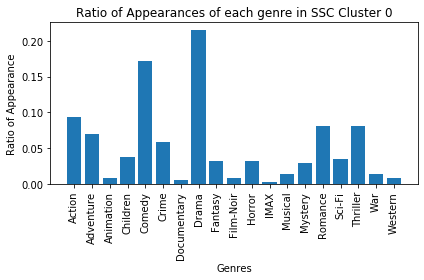

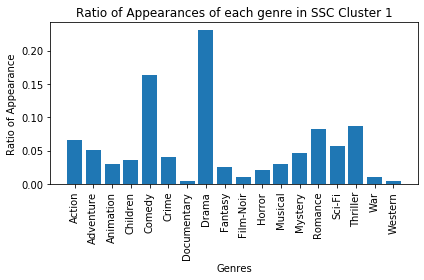

In [46]:
plt.bar(sorted(ssc_0_keys), [x/np.sum(ssc_0_values) for _,x in sorted(zip(ssc_0_keys,ssc_0_values))], align='center')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Ratio of Appearance')
plt.title('Ratio of Appearances of each genre in SSC Cluster 0')
plt.tight_layout()
#plt.savefig('outputs/ssc_0_genres_final.png')
plt.show()

plt.bar(sorted(ssc_1_keys), [x/np.sum(ssc_1_values) for _,x in sorted(zip(ssc_1_keys,ssc_1_values))], align='center')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Ratio of Appearance')
plt.title('Ratio of Appearances of each genre in SSC Cluster 1')
plt.tight_layout()
#plt.savefig('outputs/ssc_1_genres_final.png')
plt.show()

### Difference of ratios in clusters

K-means Genre Ratio Difference

In [10]:
kmeans_diff = calculate_cluster_ratio_difference(kmeans_0_keys, kmeans_1_keys, kmeans_0_values, kmeans_1_values)
print(kmeans_diff)

0.2931447945092202


Spectral Clustering Genre Ratio Difference

In [11]:
spectral_diff = calculate_cluster_ratio_difference(spectral_0_keys, spectral_1_keys, spectral_0_values, spectral_1_values)
print(spectral_diff)

1.123134328358209


Sparse Subspace Clustering Genre Ratio Difference

In [12]:
ssc_diff = calculate_cluster_ratio_difference(ssc_0_keys, ssc_1_keys, ssc_0_values, ssc_1_values)
print(ssc_diff)

0.20104353011329756


Obviously, spectral clustering has a big difference in the genre ratios in the class because of the number of items in each cluster is very unbalanced. Therefore, spectral clustering clusters should be ignored for now. Comparing K-means and SSC, which both had relatively balanced clusters, K-means clusters had a bigger difference in genres. Thus, maybe in this problem setting in general, SSC was not a good choice. Increasing the data size and changing the item representation obtained earlier may make things different.

## 6. Future Directions

- Using a bigger dataset
- Incorporating Metadata, such as sessions, time of rating, etc.
- Different clustering algorithms
- Different movie representations
- Hyperparameter Tuning

## References
[1] Zhang, A., Fawaz, N., Ioannidis, S., and Montanari, A. (2012). Guess Who Rated This Movie: Identifying Users Through Subspace Clustering. 28th Conference on Uncertainty in Artificial Intelligence (UAI 2012).  
[2] Verstrepen, K., Goethals, B. (2015). Top-N Recommendation for Shared Accounts. RecSys '15: Proceedings of the 9th ACM Conference on Recommender Systems.  
[3] Jiang, J., Li, C., Chen, Y., and Wang, W. (2018). Identifying Users behind Shared Accounts in Online Streaming Services. SIGIR’18, July 8-12, 2018, Ann Arbor, MI, USA.  
[4] Elhamifar, E. and Vidal, R. (2009). Sparse subspace clustering. Computer Vision and Pattern Recognition, 2009.  
[5] Vidal, R., Ma, Y., and Sastry, S. (2005). Generalized principal component analysis (gpca). IEEE Transactions on Pattern Analysis and Machine Intelligence, vol 27, no 12, 2005.   